https://docs.nexosis.com/clients/python

In [1]:
import json
import nexosisapi
from nexosisapi.column_metadata import ColumnMetadata
import dateutil.parser as date_parser
import pandas as pd
import seaborn as sns
import iso8601
%matplotlib inline

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            api_params = json.load(fp)
    except Exception as e:
        print('Failed to load API secrets key: {}'.format(e))
        api_params = None
    return api_params['key']

I will load my API key from a local JSON file to keep my credentials secure.

In [2]:
API_key_filepath = '/Users/robincole/Desktop/Nexosis_API_key.json'
API_key = load_api_secrets(API_key_filepath)

I've downloaded the .csv data locally

In [3]:
data_path = "/Users/robincole/Documents/Data/Nexosis/LocationA.csv"

Lets have a look at the data using Pandas

In [4]:
df = pd.read_csv(data_path, index_col=0)
df.head()

,sales,transactions
timeStamp,,
31/12/12 00:00,2922.13,459
01/01/13 00:00,1500.56,195
02/01/13 00:00,4078.52,696
03/01/13 00:00,4545.69,743
04/01/13 00:00,4872.63,797


In [5]:
df.index[0] # Our index data is a string timestamp, and not in ISO-8601 format

'31/12/12 00:00'

Lets convert the index to a datetime object

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,sales,transactions
timeStamp,,
2012-12-31,2922.13,459
2013-01-01,1500.56,195
2013-02-01,4078.52,696
2013-03-01,4545.69,743
2013-04-01,4872.63,797


In [8]:
"The data has {} entries".format(df.shape[0])

'The data has 1477 entries'

In [9]:
df['sales'][0] # Sales are floats

2922.13

In [10]:
df['transactions'][0] # transactions are int

459

OK so we have on each day, a record of the value of sales (guess dollars) and the number of transactions

In [11]:
"We have {} years of data".format(round((df.index[-1] - df.index[0]).days/365, 0))

'We have 4.0 years of data'

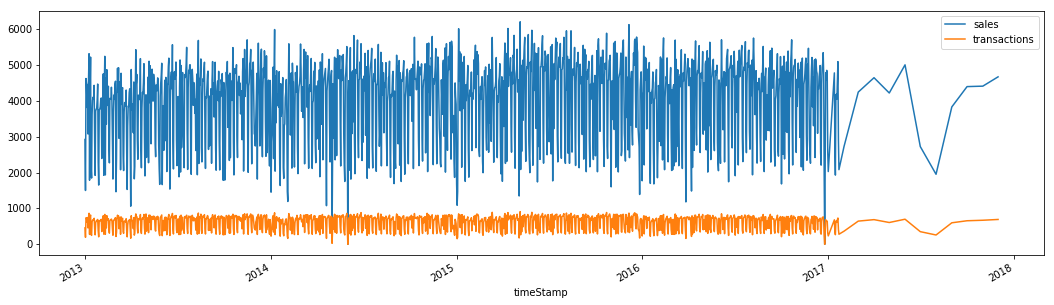

In [12]:
df.plot(figsize=(18,5));

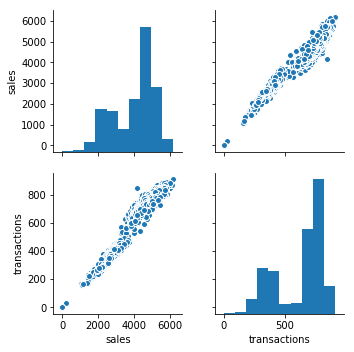

In [13]:
sns.pairplot(df);

OK so we have a bimodal distribution, likely weekday and weekend sales.

## Nexosis
We will upload our data to nexosis. It requires that timestamps are in [ISO-8601 format](https://docs.nexosis.com/guides/working-with-dates) - use `date.isoformat()`.

Note that when uploading data to nexosis, the contents of the columns are automatically inferred.

In [14]:
test_timestamp = df.index[0]
test_timestamp

Timestamp('2012-12-31 00:00:00')

In [15]:
test_timestamp.isoformat()

'2012-12-31T00:00:00'

In [16]:
%%time
client = nexosisapi.Client(API_key)

CPU times: user 23 µs, sys: 1e+03 ns, total: 24 µs
Wall time: 27.9 µs


In [17]:
with open(data_path) as f:
    result = client.datasets.create_csv('widget-sales', f)

In [18]:
columns = {
        'timeStamp': ColumnMetadata({'dataType': 'date', 'role': 'timestamp'}), 
        'sales': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'}), 
        'column1': ColumnMetadata({'dataType': 'date', 'role': 'feature'}),
        'column2': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'}),
        'column3': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'}),
        'transactions': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'})
}

In [19]:
client.datasets.create('widget-sales', [], columns)

ClientError: ('/data/widget-sales', 400, {'statusCode': 400, 'message': 'You may not specify a key or timestamp for the dataset once it has already been created. In order to specify a key or timestamp, the dataset must be recreated', 'errorType': 'InvalidColumnMetadata', 'errorDetails': {'timeStamp': ['You may not specify a key or timestamp for the dataset once it has already been created. In order to specify a key or timestamp, the dataset must be recreated', "You specified type 'date' for column 'timeStamp', but we could not successfully convert all values in the column to that type. Please check your data for formatting issues"]}})

`result` is a `datasetsummary` object https://github.com/Nexosis/nexosisclient-py/blob/master/nexosisapi/dataset_summary.py

In [ ]:
result

I added `widget-sales`

In [ ]:
result.name

In [ ]:
list(result.column_metadata.keys())

In [ ]:
result.column_metadata.get('timeStamp')

OK nexosis has incorrectly inferred that the `timeStamp` is a `text` datatype (the data is posted as `text` as we can see [here](https://github.com/Nexosis/nexosisclient-py/blob/e38530a25ed190757432dc0ba27505672d400c29/nexosisapi/client/datasets.py#L34)). I don't see anything in the nexosis API for changing the column datatype. Lets see if formatting the data correctly in pandas then uploading does any better. We can use a [little trick](https://stackoverflow.com/questions/28729212/pandas-save-date-in-iso-format) to format the timestamp correctly. 

In [ ]:
edited_file = 'edited.csv'
df.to_csv(edited_file, header=False, date_format='%Y-%m-%dT%H:%M:%SZ')

In [ ]:
pd.read_csv(edited_file).loc[0][0] # Quick check that format is correct.

In [ ]:
iso8601.parse_date(pd.read_csv(edited_file).loc[0][0])

OK we are happy that the timestamp formatting is correct.

Lets upload the dataset again

In [ ]:
with open(edited_file) as f:
    result = client.datasets.create_csv('widget-sales', f)

In [ ]:
result.column_metadata.get('timeStamp')

OK again the timestamp is datatype `text`...

In [ ]:
session = client.sessions.create_forecast('widget-sales', 'transactions',
        date_parser.parse('2017-01-22 00:00:00 -0:00'), date_parser.parse('2017-02-22 00:00:00 -0:00'))

In [ ]:
# after some time passes you can get results...
results = client.sessions.get_results(session.session_id)